<a href="https://colab.research.google.com/github/OJASWIL/BBC-News/blob/main/23048618_OjaswiSharma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  Install packages
!pip install nltk
!pip install --upgrade matplotlib
!pip install --upgrade wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 97.6 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


In [103]:
# Import packages
import nltk
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve


# Download NLTK resources
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [104]:
df = pd.read_csv('/content/bbc_news_dataset.csv')

In [105]:
df.head()

,filename,category,text
0,143.txt,business,Weak dollar trims Cadbury profits\n\nThe world...
1,244.txt,business,Market unfazed by Aurora setback\n\nAs the Aur...
2,508.txt,business,HealthSouth ex-boss goes on trial\n\nThe forme...
3,064.txt,business,Lufthansa may sue over Bush visit\n\nGerman ai...
4,432.txt,business,BA to suspend two Saudi services\n\nBritish Ai...


In [106]:
print(df['category'].value_counts())

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


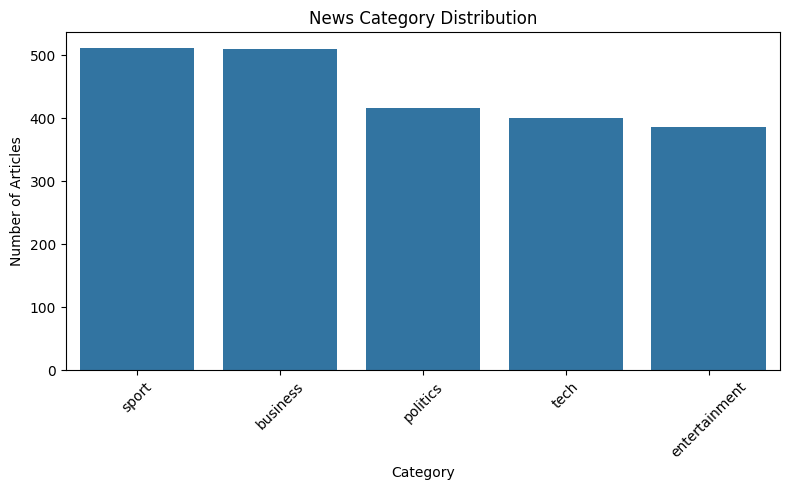

In [107]:
plt.figure(figsize=(8, 5))
sns.countplot(x='category', data=df, order=df['category'].value_counts().index)
plt.title('News Category Distribution')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [108]:
stop_words = set(stopwords.words('english'))  # Text Preprocessing
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower() #covert into lowercase
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text) # remove punctuation and replace it by space
    text = re.sub(r'\d+', '', text) # remove numbers
    tokens = word_tokenize(text) # word tokenize(split text into individual word)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]  # lemmitize tokenization , remove stop words, remove words having 2 length
    return ' '.join(tokens) # join remaining words and return clean text

df['clean_text'] = df['text'].apply(clean_text) # Applies the clean_text function to the 'text' column for each row  and stores the cleaned version in a new column named 'clean_text'

print("\nSample cleaned text:")
print(df['clean_text'].head(2)) # 2 sample test


Sample cleaned text:
0    weak dollar trim cadbury profit world biggest ...
1    market unfazed aurora setback aurora limped ba...
Name: clean_text, dtype: object


In [109]:
# 3. Train / Test split
X = df['clean_text']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {len(X_train)} samples")
print(f"Test:  {len(X_test)} samples")

Train: 1780 samples
Test:  445 samples


In [137]:
# 4. Model pipelines

nb_pipe = ImbPipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('smote', SMOTE(random_state=42)),
    ('clf', MultinomialNB())
])

svm_pipe = ImbPipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('smote', SMOTE(random_state=42)),
    ('clf', LinearSVC(random_state=42))
])
# Training
nb_pipe.fit(X_train, y_train)
svm_pipe.fit(X_train, y_train)

print("Training complete!")

Training complete!



=== Naive Bayes ===
Accuracy: 0.9618
               precision    recall  f1-score   support

     business       1.00      0.93      0.96       102
entertainment       0.97      0.95      0.96        77
     politics       0.93      0.96      0.95        84
        sport       0.97      1.00      0.99       102
         tech       0.93      0.96      0.94        80

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445



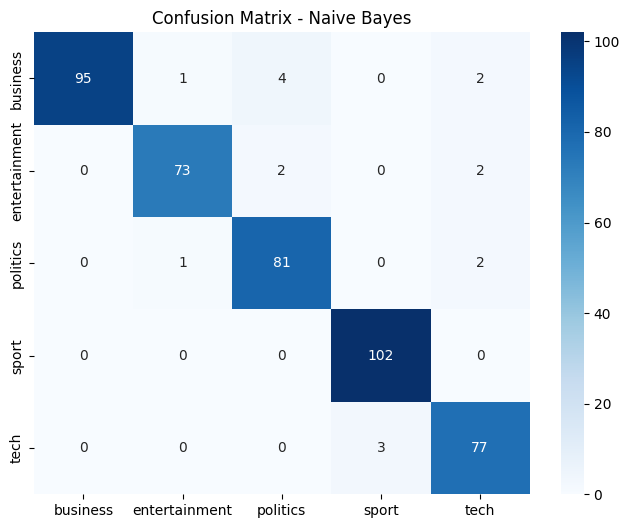


=== SVM ===
Accuracy: 0.9730
               precision    recall  f1-score   support

     business       1.00      0.94      0.97       102
entertainment       0.96      0.99      0.97        77
     politics       0.96      0.96      0.96        84
        sport       0.98      1.00      0.99       102
         tech       0.95      0.97      0.96        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



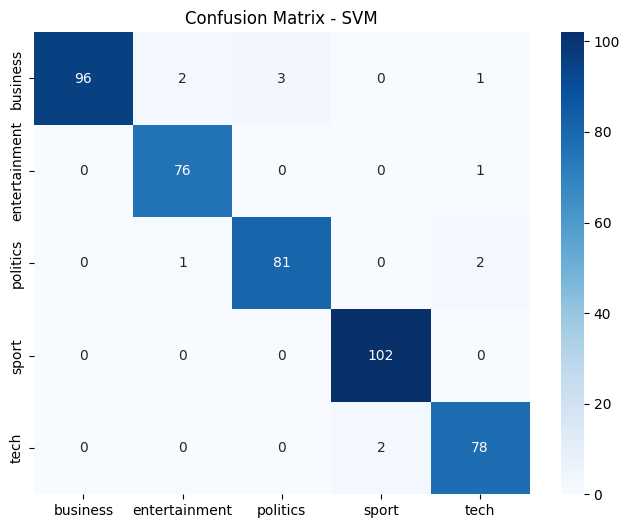

In [138]:
# 5. Evaluation
def show_results(model, name):
    pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {accuracy_score(y_test, pred):.4f}")
    print(classification_report(y_test, pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, pred, labels=model.classes_)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

show_results(nb_pipe, "Naive Bayes")
show_results(svm_pipe, "SVM")


In [139]:
# Training/Test Accuracy
nb_train_pred = nb_pipe.predict(X_train)
nb_train_acc = accuracy_score(y_train, nb_train_pred)
nb_test_acc = accuracy_score(y_test, nb_pipe.predict(X_test))

svm_train_pred = svm_pipe.predict(X_train)
svm_train_acc = accuracy_score(y_train, svm_train_pred)
svm_test_acc = accuracy_score(y_test, svm_pipe.predict(X_test))

print("Training/Test Accuracy ")
print(f"Naive Bayes  → Train: {nb_train_acc:.4f} | Test: {nb_test_acc:.4f} | Gap: {nb_train_acc - nb_test_acc:.4f}")
print(f"SVM          → Train: {svm_train_acc:.4f} | Test: {svm_test_acc:.4f} | Gap: {svm_train_acc - svm_test_acc:.4f}\n")

if nb_train_acc - nb_test_acc > 0.02:
    print("Naive Bayes: overfitting")
else:
    print("Naive Bayes: Perfect fit")

if svm_train_acc - svm_test_acc > 0.02:
    print("SVM: overfitting")
else:
    print("SVM: Perfect fit\n")

Training/Test Accuracy 
Naive Bayes  → Train: 0.9854 | Test: 0.9618 | Gap: 0.0236
SVM          → Train: 1.0000 | Test: 0.9730 | Gap: 0.0270

Naive Bayes: overfitting
SVM: overfitting


In [140]:
# Cross-Validation Score
print("Cross Validation")
nb_cv = cross_val_score(nb_pipe, X_train, y_train, cv=5)
svm_cv = cross_val_score(svm_pipe, X_train, y_train, cv=5)

print(f"Naive Bayes CV Accuracy: {nb_cv.mean():.4f} (± {nb_cv.std()*2:.4f})")
print(f"SVM CV Accuracy        : {svm_cv.mean():.4f} (± {svm_cv.std()*2:.4f})\n")

Cross Validation
Naive Bayes CV Accuracy: 0.9742 (± 0.0109)
SVM CV Accuracy        : 0.9713 (± 0.0144)



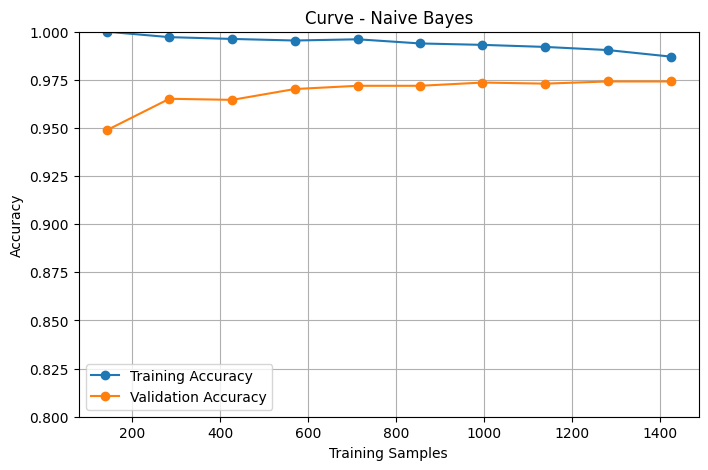

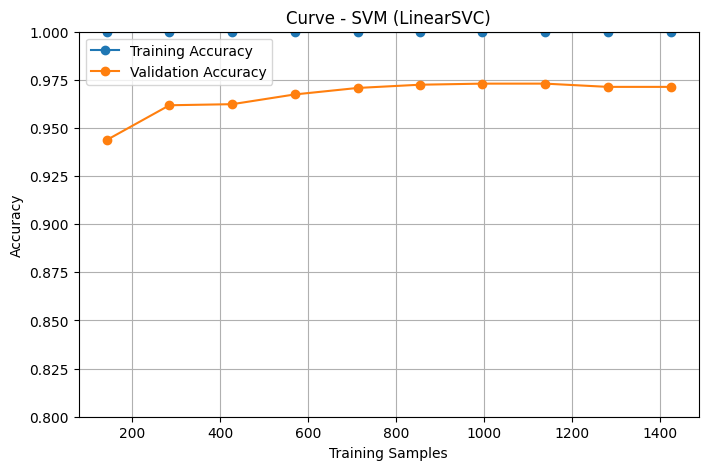

In [141]:
def plot_learning_curve(model, name):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy', random_state=42)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Training Accuracy")
    plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label="Validation Accuracy")
    plt.title(f"Curve - {name}")
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.ylim(0.8, 1.0)
    plt.show()

plot_learning_curve(nb_pipe, "Naive Bayes")
plot_learning_curve(svm_pipe, "SVM (LinearSVC)")

Generating Word Cloud for: BUSINESS


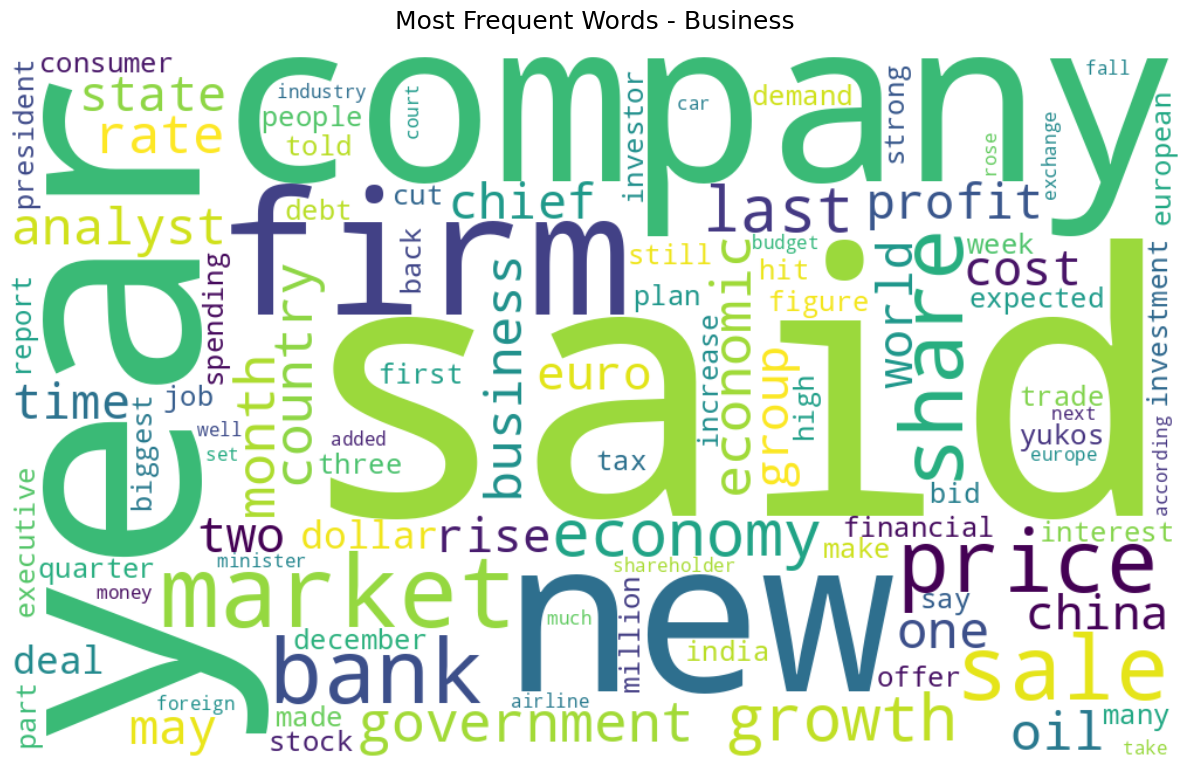

Generating Word Cloud for: SPORT


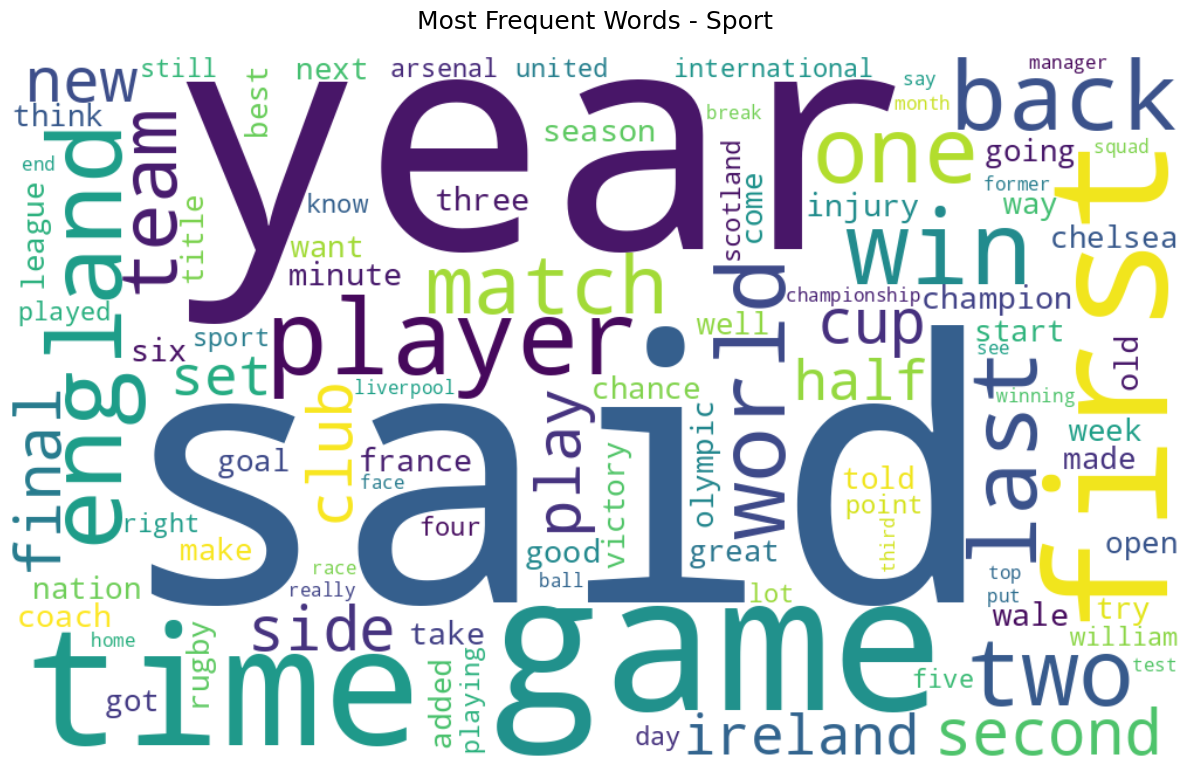

Generating Word Cloud for: POLITICS


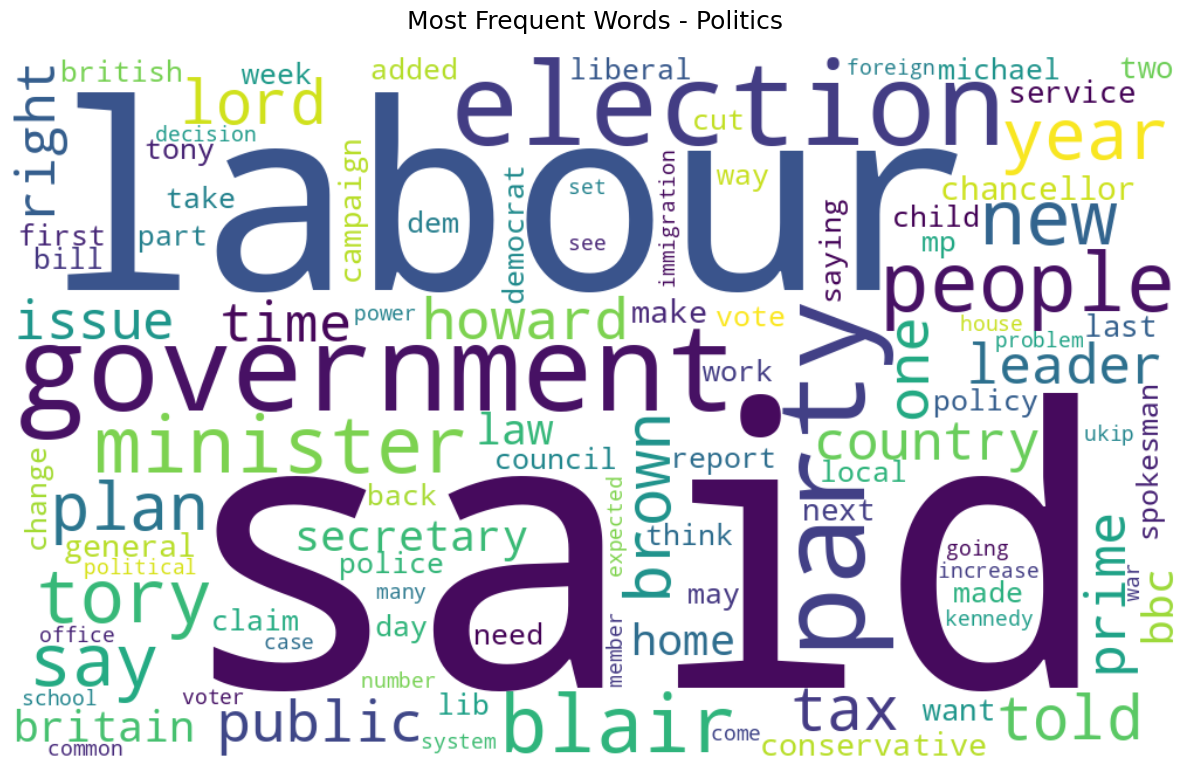

Generating Word Cloud for: TECH


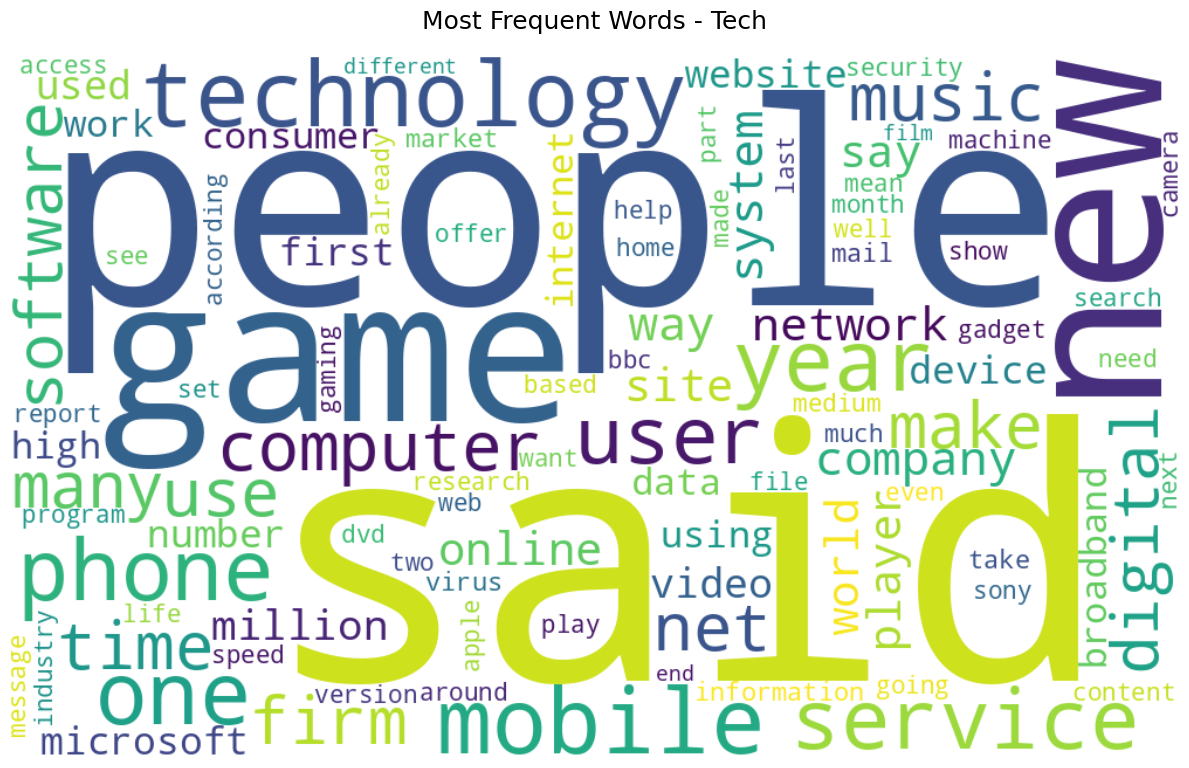

Generating Word Cloud for: ENTERTAINMENT


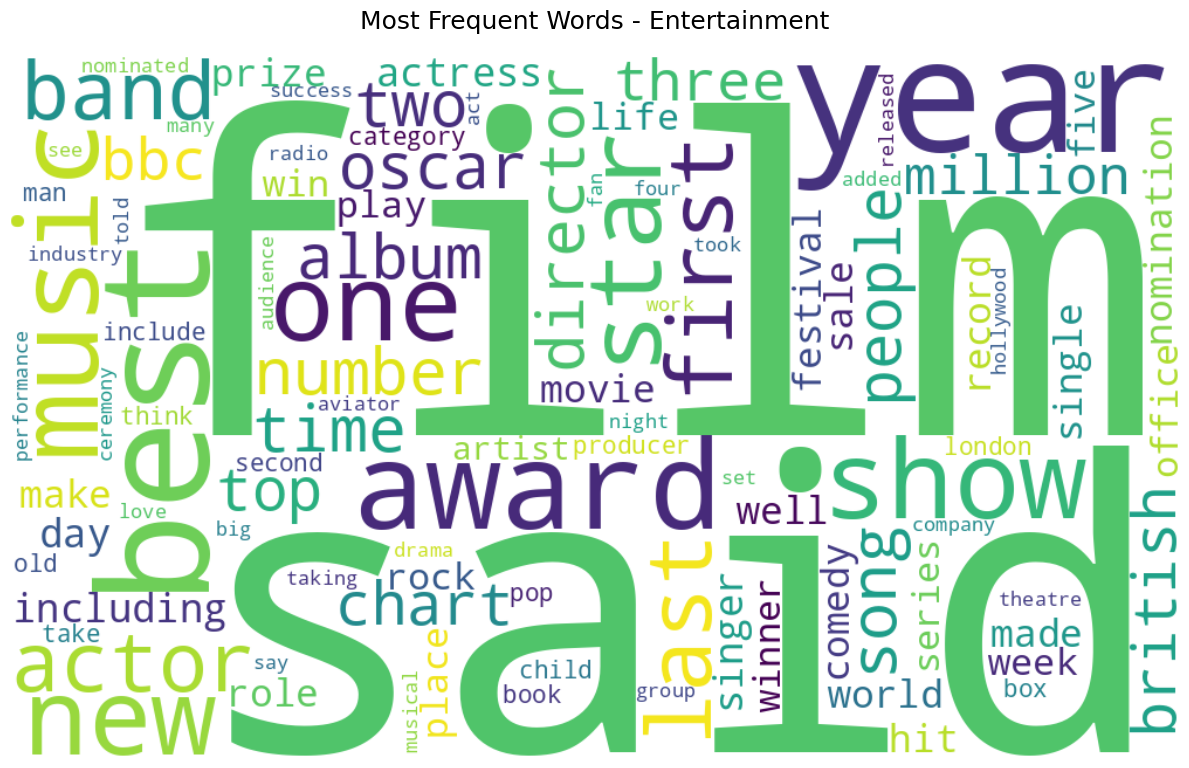

In [142]:
categories = ['business', 'sport', 'politics', 'tech', 'entertainment']

for cat in categories:
    cat_text = ' '.join(df[df['category'] == cat]['clean_text'])

    if len(cat_text.strip()) == 0:
        print(f"No text available for {cat}")
        continue

    print(f"Generating Word Cloud for: {cat.upper()}")

    wc = WordCloud(
        width=1000,
        height=600,
        background_color='white',
        max_words=100,
        min_font_size=10,
        collocations=False
    ).generate(cat_text)

    img = wc.to_image()


    plt.figure(figsize=(12, 8))
    plt.imshow(img, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Most Frequent Words - {cat.capitalize()}", fontsize=18, pad=20)
    plt.tight_layout()
    plt.savefig(f"wordcloud_{cat}.png", dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    plt.close()